<img src="../_static/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

# Standard Scikit-learn Classification Summary with FACET

***

FACET is composed of the following key components:

- **Model Inspection**

    FACET introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about FACET's model inspection capabilities, see the getting started example below.


- **Model Simulation**

    FACET's model simulation algorithms use ML models for *virtual experiments* to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, FACET utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of FACET’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    FACET offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. FACET also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.    

***

**Context**

In this tutorial notebook we will first build a classifier for predicting customer churn using a well known datasets from [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn). Then using the developed classifier we will demonstrate how to perform selected typical model performance summary tasks including:
- Using a final fitted model on all CV-folds to obtain a confusion matrix, classification report and precision-recall curve
- Using models fitted to each CV fold, create a set of summary metrics and a ROC curve both with an assessment of error based on the cross-validation

***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [Quick data preparation](#Quick-data-preparation)
3. [Preprocessing and feature selection](#Preprocessing-and-feature-selection)
4. [Learner selection with FACET](#Learner-selection-with-FACET)
5. [Using the final fitted model](#Using-the-final-fitted-model)
6. [Using the crossfit for the best model](#Using-the-crossfit-for-the-best-model)

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


# ignore irrelevant warnings that would affect the output of this tutorial notebook

import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")
warnings.filterwarnings("ignore", message=r".*`should_run_async` will not call `transform_cell`")
warnings.filterwarnings("ignore", message=r".*`np\..*` is a deprecated alias")


# set global options for matplotlib

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
matplotlib.rcParams["figure.dpi"] = 72

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, sklearn, etc.)
2. Required FACET classes (i.e., selection)
3. Other BCG GAMMA packages which simplify pipelining (sklearndf, see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)) when using FACET

**Common package imports**

In [2]:
import numpy as np
import pandas as pd
from numpy import interp
import matplotlib.pylab as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    auc,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
)
from sklearn.compose import make_column_selector
from sklearn.model_selection import RepeatedKFold

**FACET imports**

In [3]:
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid
from facet.crossfit import LearnerCrossfit

**sklearndf imports**

Instead of using the "regular" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas data frames. Additionally, the names of all your favourite scikit-learn functions are the same except for `DF` on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`

In [4]:
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.transformation import (
    ColumnTransformerDF,
    OneHotEncoderDF,
    SimpleImputerDF,
)
from sklearndf.transformation.extra import BorutaDF

# Quick data preparation

We start by obtaining a dataset for analysis. In this case we use the well known Telco Customer Churn dataset from [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn).

Briefly, the dataset contains one row for each of 7043 customers and includes information on those who left with the last month (i.e., `Churn` - our target of interest, n=1869), services signed up for, account information and demographics.

As this dataset has been well described and analyzed, we apply the minimum number of steps necessary to prepare the data for this tutorial. These are as follows:

- drop the `customerID` column
- convert `TotalCharges` to numeric type
- convert `SeniorCitizen` to string type
- relabel and convert `Churn` to a 0/1 target

Finally we place the dataframe in a FACET `Sample` object for easier data management. This allows us to:

- Quickly access the target vs. features
- Pass our data into sklearndf pipelines
- Pass information to other FACET functions

In [5]:
# This dataset is from Kaggle has been analyzed numerous times, and so we skip EDA
# read in the data
churn_df = pd.read_csv('KAGGLE-Telco-Customer-Churn.csv')

# drop customer ID
churn_df = churn_df.drop(columns=['customerID'])

# TotalCharges needs to be float (known to have a few missing values)
churn_df.TotalCharges = pd.to_numeric(churn_df.TotalCharges, errors='coerce')

# To support preprocessing pipeline we will also convert SeniorCitizen to object type
# only tenure, MonthlyCharges and TotalCharges are numeric
churn_df.SeniorCitizen = churn_df.SeniorCitizen.astype(str)

# Create a new 0/1 target where 1=churn
churn_df.Churn = churn_df.Churn.map(dict(Yes=1, No=0))

# create sample object
churn_sample = Sample(
    observations=churn_df,
    feature_names=churn_df.drop(columns=["Churn"]).columns,
    target_name="Churn",
)

# check target name
churn_sample.target_name

'Churn'

In [6]:
# get feature names
churn_sample.feature_names

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

# Preprocessing and feature selection

Our first step is to create a minimum preprocessing pipeline which based on our dataset needs to address the following:

- Simple imputation for missing values

- One-hot encoding for categorical features

We will use the sklearndf wrappers for scikit-learn functions such as `SimpleImputerDF` in place of `SimpleImputer`, `OneHotEncoderDF` in place of `OneHotEncoder`, and so on.

In [7]:
# for categorical features we will use the mode as the imputation value and also one-hot encode
preprocessing_categorical = PipelineDF(
    steps=[
        ("imputer", SimpleImputerDF(strategy="most_frequent", fill_value="<na>")),
        ("one-hot", OneHotEncoderDF(sparse=False, handle_unknown="ignore")),
    ]
)

# for numeric features we will impute using the median
preprocessing_numerical = SimpleImputerDF(strategy="median")

# put the pipeline together
preprocessing_features = ColumnTransformerDF(
    transformers=[
        (
            "categorical",
            preprocessing_categorical,
            make_column_selector(dtype_include=object),
        ),
        (
            "numerical",
            preprocessing_numerical,
            make_column_selector(dtype_include=np.number),
        ),
    ]
)

Next, we perform some initial feature selection using Boruta, a recent approach shown to have quite good performance. The Boruta algorithm removes features that are no more predictive than random noise. If you are interested further, please see this [article](https://www.jstatsoft.org/article/view/v036i11).

The `BorutaDF` transformer in our sklearndf package provides easy access to this powerful method. The approach relies on a tree-based learner, usually a random forest. For settings, a `max_depth` of between 3 and 7 is typically recommended, and here we rely on the default setting of 5. However, as this depends on the number of features and the complexity of interactions one could also explore the sensitivity of feature selection to this parameter. The number of trees is automatically managed by the Boruta feature selector argument `n_estimators="auto"`.

We also use parallelization for the random forest using `n_jobs` to accelerate the Boruta iterations.

In [8]:
# create the pipeline for Boruta
boruta_feature_selection = PipelineDF(
    steps=[
        ("preprocessing", preprocessing_features),
        (
            "boruta",
            BorutaDF(
                estimator=RandomForestClassifierDF(
                    max_depth=5, n_jobs=-3, random_state=42
                ),
                n_estimators="auto",
                random_state=42,
                verbose=False,
            ),
        ),
    ]
)

# run feature selection using Boruta and report those selected
boruta_feature_selection.fit(X=churn_sample.features, y=churn_sample.target)
selected = boruta_feature_selection.feature_names_original_.unique()
selected

array(['InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object)

# Learner selection with FACET

FACET implements several additional useful wrappers which simplify comparing and tuning models:

- `LearnerGrid`: allows you to pass a learner pipeline (i.e., classifier + any preprocessing) and a set of hyperparameters

- `LearnerRanker`: multiple LearnerGrids can be passed into this class as a list - this allows tuning hyperparameters both across different types of learners in a single step and ranks the resulting models accordingly

For the purpose of this tutorial we will assess a Random Forest Classifier and hyperparameter ranges will be assessed using 10 repeated 5-fold cross-validation and be scored using AUC:

Random forest: with hyperparameters

- max_depth: [4, 8, 16, 32]

- n_estimators: [200, 500]

Learner ranking uses the average performance minus two times the standard deviation, so that we consider both the average performance and variability when selecting a classifier.

If you want a list of available hyperparameters you can use `classifier_name().get_params().keys()` where `classifier_name` could be for example `RandomForestClassifierDF` and if you want to see the default values, just use `classifier_name().get_params()`.

In [9]:
# reduce sample object to selected features
churn_sample_kept_features = churn_sample.keep(feature_names=selected)

# Classifier pipeline composed of the feature preprocessing steps created earlier and random forest learner
rforest_clf = ClassifierPipelineDF(
    preprocessing=preprocessing_features,
    classifier=RandomForestClassifierDF(random_state=42),
)

# set grid of hyper-parameters 
classifier_grid = [
    LearnerGrid(
        pipeline=rforest_clf,
        learner_parameters={"max_depth": [4, 8, 16, 32], "n_estimators": [200, 500]},
    ),
]

# run the learner ranker
clf_ranker = LearnerRanker(
    grids=classifier_grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring="roc_auc",
).fit(churn_sample_kept_features)

# look at results
clf_ranker.summary_report()

ranking_score   roc_auc                          classifier               \
                        mean       std                      type n_estimators   
rank                                                                            
0         0.825502  0.846088  0.010293  RandomForestClassifierDF          500   
1         0.825480  0.845925  0.010223  RandomForestClassifierDF          200   
2         0.821349  0.842705  0.010678  RandomForestClassifierDF          200   
3         0.820969  0.842484  0.010758  RandomForestClassifierDF          500   
4         0.801712  0.822412  0.010350  RandomForestClassifierDF          500   
5         0.800908  0.821515  0.010304  RandomForestClassifierDF          200   
6         0.794795  0.816196  0.010701  RandomForestClassifierDF          500   
7         0.794210  0.815416  0.010603  RandomForestClassifierDF          200   

                
     max_depth  
rank            
0            8  
1            8  
2            4  
3            4  
4           16  
5           16  
6           32  
7           32

# Using the final fitted model

As part of the `clf_ranker` we can access a final model (`best_model_`) that represents the selected best model but re-fit using all available training data. With this model we can then predict either the class or the probability (score) and generate standard scikit-learn classifier performance summaries such as a classification report, confusion matrix or precision-recall curve.

In [10]:
# obtain required quantities
y_pred = clf_ranker.best_model_.predict(churn_sample_kept_features.features)
y_prob = clf_ranker.best_model_.predict_proba(churn_sample_kept_features.features)[1]
y_true = churn_sample_kept_features.target

## Classification Report

The classification report from scikit-learn is often used as a summary for classifiers, especially in the case of imbalanced datasets, as it provides precision, recall and the f1-score by class along with the support (number of observations for a class). For more information on the implementation in scikit-learn please see [sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report).

In [11]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      5174
           1       0.72      0.57      0.63      1869

    accuracy                           0.83      7043
   macro avg       0.79      0.74      0.76      7043
weighted avg       0.82      0.83      0.82      7043



## Confusion Matrix

The confusion matrix can be used to evaluate the accuracy of the fitted classifier by comparing the predicted class to the observed class. For more information on the implementation in scikit-learn please see [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

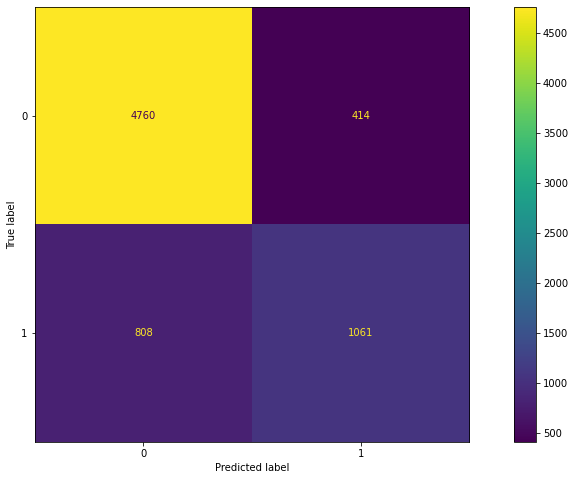

In [12]:
cf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cf_matrix).plot()

## Precision-recall curve

The precision-recall curve is helpful for understanding the trade off between precision (positive predictive value) and recall (sensitivity) according to a specified threshold applied to the predicted probability (or score) for determining the predicted class for an observation. For more information on the implementation in scikit-learn please see [sklearn.metrics.precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve).

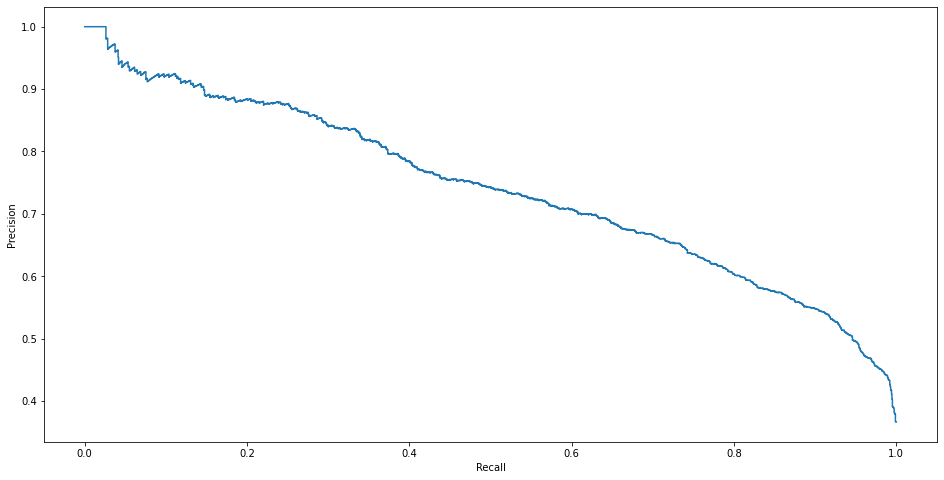

In [13]:
prec, recall, _ = precision_recall_curve(y_true, y_prob, pos_label=1)
PrecisionRecallDisplay(precision=prec, recall=recall).plot()

# Using the crossfit for the best model

The `clf_ranker` also contains a crossfit object (`best_model_crossfit_`) which allows us to access the test training splits from the cross-validation via `.splits()` and the best model fit on each splits training set via `.models()`.

With this information we can iterate over the cross-validation splits and generate performance metrics (or any other summary) for each trained model, providing a set of results. This is often useful when we want to get some sense of the variability in performance across the cross-validation folds. This is also exactly what the `LearnerRanker` is doing for the specified performance metric to get obtain average performance - 2 standard deviations.

Here we give two examples, the first is summarising the mean performance and standard deviation for a selection of common classifier performance metrics, and the second, is creating an average ROC curve with an assessment of variability across folds by plotting the RCO curve $\pm$ 1 standard deviation.

## Panel of metrics with error from cross-validation

As cross-validation is intended to inform us about average performance on a test-set, it can be helpful to collate statistics about the variability of performance as well. Below we demonstrate how to use the best model crossfit object to obtain both the mean and standard deviation for a set of common classification metrics: Accuracy, F1, Precision, Recall and AUC. This approach can of course be adapted to any metric and any summary thereof.

For more information about classifier metrics in scikit-learn please see [classification-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

Text(0.5, 1.0, 'Summary of model performance')

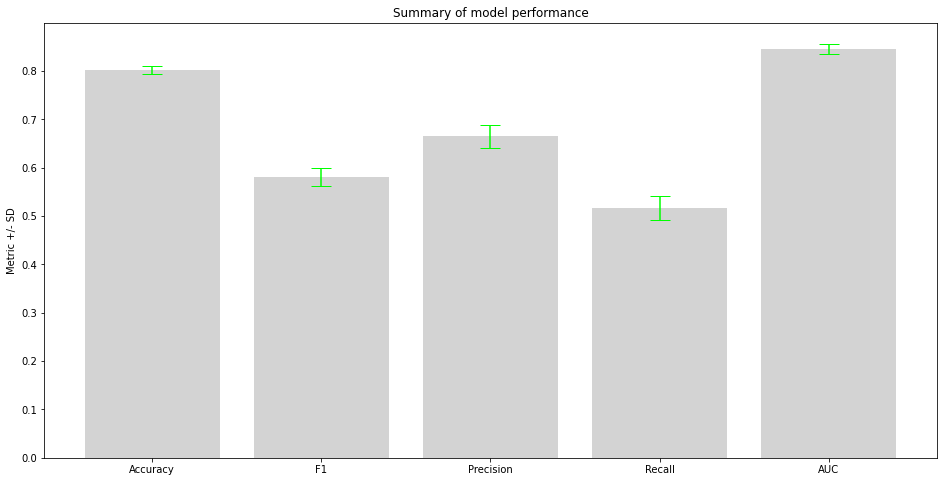

In [14]:
metrics = []

# use established crossfit which contains all splits and fitted models
best_crossfit = clf_ranker.best_model_crossfit_
for (train_index, test_index), model in zip(best_crossfit.splits(), best_crossfit.models()):
    
    # get required target outputs
    y_true = churn_sample_kept_features.target[test_index]
    y_prob = model.predict_proba(churn_sample_kept_features.features.iloc[test_index])[1]
    y_pred = model.predict(churn_sample_kept_features.features.iloc[test_index])
    
    # calculate metrics
    metrics.append(pd.Series({
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob)}))
                   
# collect required summaries and plot
metrics_df = pd.DataFrame(metrics)
fig, ax = plt.subplots()
ax.bar(
    metrics_df.columns,
    metrics_df.mean(),
    yerr=metrics_df.std(),
    align='center',
    ecolor='lime',
    capsize=10,
    color='lightgrey'
)
ax.set_ylabel('Metric +/- SD')
ax.set_title('Summary of model performance')

## ROC Curve with error based on cross-validation

Another common performance summary for a classifier is the ROC curve which shows the trade of between the False Positive Rate and the True Positive Rate at all classification thresholds. While we can plot one curve for the best model, using the crossfit object we can get an assessment of the standard deviation at each threshold and in turn capture some information about the variability of the ROC curve.

For more information about cross-validation ROC curves in scikit-learn please see the basis for this example here: [plot_roc_crossval](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py).

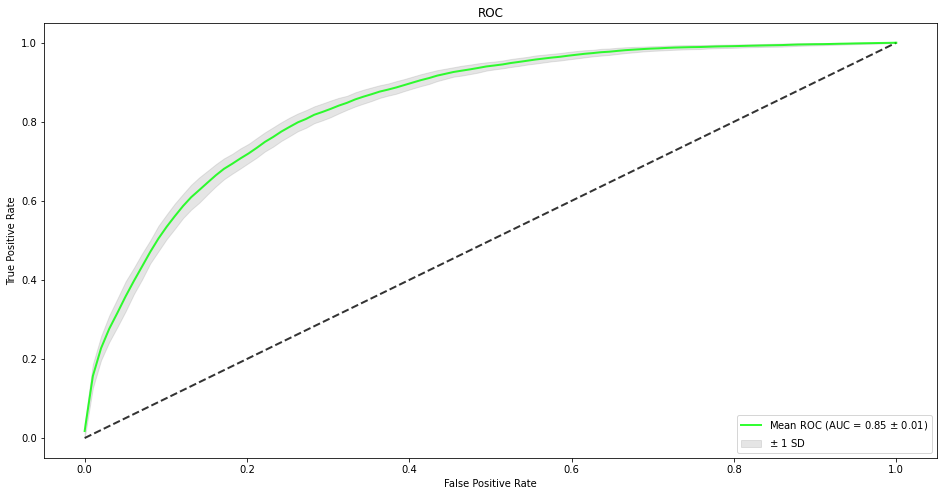

In [15]:
# define plotting function
def roc_plot(fpr, tpr, tpr_std, auc, auc_std):

    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)
    ax.plot(fpr, tpr, color='lime', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (auc, auc_std), lw=2, alpha=.8)
    tpr_upper = np.minimum(tpr + tpr_std, 1)
    tpr_lower = np.maximum(tpr - tpr_std, 0)
    ax.fill_between(fpr, tpr_lower, tpr_upper, color='grey', alpha=.2, label=r'$\pm$ 1 SD')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC')
    ax.legend(loc='lower right')
    plt.show()
    
# some set-up
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# use established crossfit which contains all splits and fitted models
best_crossfit = clf_ranker.best_model_crossfit_
for (train_index, test_index), model in zip(best_crossfit.splits(), best_crossfit.models()):
    
    # predict probability for a splits test set using the fitted model
    prediction = model.predict_proba(churn_sample_kept_features.features.iloc[test_index])
    
    # calculate roc curve and interpolate true positive rate
    fpr, tpr, t = roc_curve(churn_sample_kept_features.target[test_index], prediction[1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    
    # calculate AUC
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

# collect required summaries
auc_mean, auc_std = np.mean(aucs), np.std(aucs)
mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)

# create plot
roc_plot(mean_fpr, mean_tpr, std_tpr, auc_mean, auc_std)